In [21]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [22]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [23]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [24]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [25]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
def cmp(s, dt, t):
  # print("t.grad: ", t.grad)
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [26]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 64 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(214748367) # for reproducibility


# write your own C, W1, B1, W2, B2, BN_GAIN  BN_BIAS
C = torch.randn((vocab_size, n_embd), generator=g)

# W1 = torch.randn((block_size * n_embed, n_hidden), generator=g) / (block_size * n_embd) ** 0.5
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3) / ((block_size * n_embd) ** 0.5)   # kaiming normal: std = gain/sqrt(fani_in)

# Note: I am initializating many of these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could mask an incorrect
# implementation of the backward pass.

# standard set-up: b1 = torch.zeros(n_hidden) # or torch.zeros((1, n_hidden))
b1 = torch.randn(n_hidden, generator=g) *0.1 # for fun, not needed since we have BN layer

# output  after 1st linear is (batch_size, n_hidden), BatchNorm  does average of neuron values along first dimension out.mean(0, keepdim) -> bn_mean.shape (1, n_hidden)
#standard way: ones for bngain = torch.ones(n_hidden) # -> broadcast to (1, n_hidden)  when * (out - bnmean)
# zeros for bnbias = torch.zeros(n_hidden) 
bngain = torch.randn((1, n_hidden))*0.1 + 1.0  #make it normal around mean 1
bnbias = torch.randn((1, n_hidden))*0.1

# W2 = torch.randn((n_hidden, vocab_size), generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
# b2 = torch.zeros(vocab_size)
b2 = torch.randn(vocab_size, generator=g) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

4137


In [27]:
g = torch.Generator().manual_seed(214748367) # for reproducibility

batch_size = 32
n = batch_size
# n = batch_size # a shorter variable also, for convenience

# construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
# print("Xb: ", Xb)
# print("Yb: ", Yb)

# fill-in forward pass 
# embedding layer
embd = C[Xb]  # index C.shape[vocab_size, n_embd] by shape [batch_size, block_size] result in [batch_size, block_size, n_embd]
embdflat = embd.view(embd.shape[0], -1)
# print("embdflat: ", embdflat)

# linear
h_prebn = embdflat @ W1 + b1  # shape [batch_size, n_hidden]
# print("h_prebn: ", h_prebn)

# # BatchNorm layer
# batch norm formular: gain * {(x - E[x]) / sqrt( var(x) + eps )} + bias

bn_sumi = h_prebn.sum(0, keepdim=True) # [1, n_hidden], do  not forget divide by n
bn_meani = bn_sumi * (batch_size ** -1) # do not forget divide by n

# bn_vari = h_prebn.var(0, keepdim=True)
# wrong : bn_diff = (h_prebn - bn_meani) * bngain  later *bngain better
bn_diff = h_prebn - bn_meani
bn_se = bn_diff ** 2
bn_sse = bn_se.sum(0, keepdim=True)

# # note: Bessel's correction (dividing by n-1, not n),  think of sample variance
# sample variance formula: 1/(n-1) * sum of (x - x_mean)^2
bn_var = ((batch_size-1)** -1 ) * bn_sse    
bn_denominator = (bn_var + 1e-5) ** (-1/2)
bn_raw = bn_diff * bn_denominator

bn_out = bngain * bn_raw + bnbias
# print("bn_out: ", bn_out)

h = torch.tanh(bn_out)
# print("tanh h: ", h)

logits = h @ W2 + b2
# print("logits: ", logits)

####
# loss_fast = F.cross_entropy(logits, Yb)
# print("loss_fast: ", loss_fast) 
#####
# DO NOT FORGET  subtract max 
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability

logits_exp = torch.exp(norm_logits)
logits_exp_sum = logits_exp.sum(1, keepdim=True)
logits_exp_sum_inv = logits_exp_sum**-1
logits_likelihood = logits_exp * logits_exp_sum_inv
# print("softmax(logits): ", logits_likelihood)

#logits_likelihood[:, Yb]  # wrong

##### work, but there's easy eay
# Yb_onehot = F.one_hot(Yb, num_classes=vocab_size)
# print("Yb_onehot: ", Yb_onehot)
# prob = logits_likelihood * Yb_onehot
# target_probs = prob.max(1, keepdim=True).values
#####
target_probs = logits_likelihood[range(batch_size), Yb] 

# print("target_probs: ", target_probs)
target_probs_log = -torch.log(target_probs)

loss = target_probs_log.sum() / batch_size
# print("loss: ", loss)  #loss:  tensor(5.8324, grad_fn=<DivBackward0>)


# PyTorch backward pass
for p in parameters:
  p.grad = None
    
for t in [target_probs_log, target_probs, logits_likelihood, logits_exp_sum_inv, logits_exp_sum, logits_exp, # afaik there is no cleaner way
          norm_logits, logit_maxes, logits, h, bn_out, bn_raw, bn_denominator, bn_var, bn_sse, bn_se, bn_diff,  bn_meani, bn_sumi, 
          h_prebn, embdflat, embd, C]:
  t.retain_grad()
    
loss.backward(retain_graph=True)
loss

tensor(3.3910, grad_fn=<DivBackward0>)

In [29]:
# Exercise 1: backprop through the whole thing manually, 
# backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

# loss = target_probs_log.sum() / batch_size  # [a, b] -> (a+b)/2 -> grad:[0.5, 0.5]
d_target_probs_log = torch.full((batch_size,), 1.0/batch_size)
# print("d_target_probs_log: ", d_target_probs_log)
cmp('target_probs_log', d_target_probs_log, target_probs_log)

# target_probs_log = -torch.log(target_probs)  dlog(x) = 1/x
d_target_probs = - (target_probs**-1) * d_target_probs_log  #  * for element-wise multiplication
# print("d_target_probs: ", d_target_probs)
cmp('target_probs', d_target_probs, target_probs)

#target_probs = logits_likelihood[range(batch_size), Yb] # x.grads always have the same shape as x, only probs @ index of Yb have grad, other have no impact 
d_logits_likelihood = torch.zeros_like(logits_likelihood)
d_logits_likelihood[range(batch_size), Yb] = 1.0 * d_target_probs
# print("d_logits_likelihood: ", d_logits_likelihood)
cmp('d_logits_likelihood', d_logits_likelihood, logits_likelihood)

# logits_likelihood = logits_exp * logits_exp_sum_inv   # note logits_exp_sum_inv [batch_size, 1] got broadcast here
# wrong:d_logits_exp_sum_inv = torch.zeros_like(logits_exp_sum_inv)
# d_logits_exp_sum_inv[range(batch_size), :] = logits_exp * d_logits_likelihood  # no need to broadcast here
d_logits_exp_sum_inv = (logits_exp  * d_logits_likelihood).sum(1, keepdim=True)
# print("d_logits_exp_sum_inv: ", d_logits_exp_sum_inv)
cmp('d_logits_exp_sum_inv', d_logits_exp_sum_inv, logits_exp_sum_inv)

d_logits_exp = logits_exp_sum_inv * d_logits_likelihood # wait for another path to logits_exp

# logits_exp_sum_inv = logits_exp_sum**-1
d_logits_exp_sum = - (logits_exp_sum ** -2) * d_logits_exp_sum_inv
# print("d_logits_exp_sum: ", d_logits_exp_sum)
cmp("d_logits_exp_sum: ", d_logits_exp_sum, logits_exp_sum)

# logits_exp_sum = logits_exp.sum(1, keepdim=True)
d_logits_exp_here = torch.zeros_like(logits_exp)
d_logits_exp_here[:, :] = 1.0 * d_logits_exp_sum
d_logits_exp += d_logits_exp_here   # do not forget to combine with the other path 
# print("d_logits_exp: ", d_logits_exp)
cmp("d_logits_exp: ", d_logits_exp, logits_exp)

# logits_exp = torch.exp(norm_logits)
d_norm_logits = logits_exp * d_logits_exp
# print("d_norm_logits: ", d_norm_logits)
cmp("d_norm_logits", d_norm_logits, norm_logits)

#norm_logits = logits - logit_maxes # subtract max for numerical stability
d_logits = torch.ones_like(logits)
#### wrong
# d_logits = d_logits * d_norm_logits  # wait for another path to d_logits
# d_logit_maxes = torch.zeros_like(logit_maxes)
# # print(d_norm_logits[range(batch_size), torch.argmax(logits, 1)])
# d_logit_maxes[range(batch_size)] = -1.0 * d_norm_logits[range(batch_size), torch.argmax(logits, 1)].view(batch_size,1)
##########
# substract logit_maxes at every position, so sum of -1*out_grad
d_logit_maxes = (-1 * d_logits *  d_norm_logits).sum(1, keepdim=True) 
# print("d_logits_maxe: ", d_logit_maxes)
cmp("d_logit_maxes", d_logit_maxes, logit_maxes)

d_logits = torch.ones_like(logits)
d_logits *= d_norm_logits
# print(d_logits == torch.clone(d_norm_logits))

#logit_maxes = logits.max(1, keepdim=True).values
d_logits_here = torch.zeros_like(logits)
d_logits_here[range(batch_size), torch.argmax(logits, 1)] = 1.0
# print("d_logits_here: ", d_logits_here)
d_logits_here  = d_logits_here * d_logit_maxes
# print(d_logits_here == F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * d_logit_maxes)

d_logits += d_logits_here
# print("d_logits: ", d_logits)
cmp("d_logits", d_logits, logits)  #ha, finally! review: d_logit_maxes was wrong

# logits = h @ W2 + b2

# h.shape (2, 64) , W2.shape (64, 27)  d_logits.shape(2, 27)  b[27]
# example: h = [[a11, a12], [a21, a22]]  W2 = [[w11, w12, w13], [w21, w22, w23]]
# [[a11w11+a12w21, a11w12+a12w22, a11w13+a12w23], 
#  [a21w11+a22w21, a21w12+a22w22, a21w13+a22w23]]
# h @ W2 =  shape(2,3)   #  dont forget to chain with outer grad that is d_logits  (2,3) with corresponding grad
#[[dlogits11, dlogits12, dlogits13], 
# [dlogits21, dlogit22, dlogits23]]  

# grad w.s.t each position of bn_out # recall that in micrograd and in previous grad to sum, we infuse (cumulate) all grads that arrive at a
#[[dlogits11*w11+dlogits12*w12+dlogits13*w13, dlogits11*w21+dlogits12*w22+dlogits13*w23], 
# [dlogits21*w11+dlogits22*w12+dlogits23*w13, dlogits21*w21+dlogits22*w22+dlogits23*w23]] 
# =
#[[dlogits11, dlogits12, dlogits13],[dlogits21, dlogits22, dlogits23]] * 
# [[w11, w21],
#  [w12, w22],
#  [w13, w23]]
# which d_logits @ W.T  verify this is the only way to make the shape work (2,27) @ (27, 64)  -> (2,64)
d_h = d_logits @ W2.T
# print("d_h: ", d_h)
cmp("d_h", d_h, h)

d_W2 = h.T @ d_logits
# print("d_W2: ", d_W2)
cmp("d_W2", d_W2, W2)
# b2 is broadcasted in forward, so here we need to sum over all broadcast dimensions 
# [b1,b2, ...b27]  broadcast vertically for batches [[b1, b2, ...b27],
#                                                    [b1, b2,... b27]]
# chain with dlogits [[dlogits11, dlogit12, ....dlogits127],
#                      [dlogits21, dlogits22, ...dlogits227]]
d_b2 = d_logits.sum(0, keepdim=True)
cmp("d2", d_b2, b2)

#h = torch.tanh(bn_out) d(tanh) = 1-tanh^2
d_bnout = (1-h**2) * d_h
# print("d_bnout: ", d_bnout)
cmp("d_bnout", d_bnout, bn_out)

# bn_out = bngain * bn_raw + bnbias   # bngain, bnbias shape (1, 64)  broadcast to (2, 64), need to take sum
d_bngain = (bn_raw * d_bnout).sum(0, keepdim=True) # note () are nedded
cmp("d_bngain", d_bngain, bngain)
d_bnbias = d_bnout.sum(0, keepdim=True)
cmp("d_bnbias", d_bnbias, bnbias)
d_bnraw = bngain * d_bnout
cmp("d_bnraw", d_bnraw, bn_raw)

# bn_raw = bn_diff * bn_denominator  #bn_diff(2, 64) bn_denominator(1, 64)  d_bnraw (2, 64)
d_bn_diff = bn_denominator * d_bnraw  # wait  path bn_se = bn_diff ** 2
# cmp("d_bn_diff", d_bn_diff, bn_diff)
d_bn_denominator = (bn_diff * d_bnraw).sum(0, keepdim=True)
cmp("d_bn_denominator", d_bn_denominator, bn_denominator)

# bn_denominator = (bn_var + 1e-5) ** (-1/2)
d_bn_var = -0.5 * (bn_var+1e-5)**(-1.5) * 1 * d_bn_denominator  # note chain rule here: bn_var_1e-5 as a whole and 1 wst bn_var
cmp("d_bn_var", d_bn_var, bn_var)

# bn_var = ((batch_size-1)** -1 ) * bn_sse  
d_bn_sse = (batch_size-1)** -1 * d_bn_var
cmp("d_bn_sse", d_bn_sse, bn_sse)

#bn_sse = bn_se.sum(0, keepdim=True)  #because of sum, local grad @every position of bn_se is 1.0. 
d_bn_se = torch.ones_like(bn_se) * d_bn_sse
cmp("d_bn_se", d_bn_se, bn_se)

# bn_se = bn_diff ** 2
d_bn_diff += 2 * bn_diff * d_bn_se
cmp("d_bn_diff", d_bn_diff, bn_diff)

# bn_diff = h_prebn - bn_meani
d_h_prebn = 1 * d_bn_diff
#  hold on ,cmp("d_h_prebn", d_h_prebn, h_prebn), theres one more path
d_bn_meani = (-1 * d_bn_diff).sum(0, keepdim=True) # dont forget this d_bn_meani is (1, 64)
cmp("d_bn_meani", d_bn_meani, bn_meani)

# bn_meani = bn_sumi * (batch_size ** -1)
d_bn_sumi = (batch_size ** -1) * d_bn_meani
cmp("d_bn_sumi", d_bn_sumi, bn_sumi)

# bn_sumi = h_prebn.sum(0, keepdim=True)
d_h_prebn += torch.ones_like(h_prebn) * d_bn_sumi
cmp("d_h_prebn", d_h_prebn, h_prebn)

# h_prebn = embdflat @ W1 + b1  # here we go again d_h_prebn.shape(2, 64) embdflat.shape(2, 30) W1.shape(30, 64) b1.shape(64)
d_embdflat = d_h_prebn @ W1.T  # pay attention here is d_h_prebn, not h_prebn
cmp("d_embdflat", d_embdflat, embdflat)

d_W1 = embdflat.T @ d_h_prebn
cmp("d_W1", d_W1, W1)

# embdflat = embd.view(embd.shape[0], -1)  # embd.shape torch.Size([2, 3, 10])  -> (2, 30)
d_embd = d_embdflat.view(d_embdflat.shape[0], block_size, -1)
cmp("d_embd", d_embd, embd)

# embd = C[Xb]  # embd.shape [2, 3, 10]  C.shape[27, 10]  Xb.shape (batch_size, block_size)
#C=[ [0.2, 0.8, 0.3],      Xb = [[0,0,1],             d_embd = [ [[0.2, 0.8d, 0.3d], [0.2d, 0.8d, 0.3d], [0.5d , 0.5d, 0.3d]],  
   # [0.5, 0.5, 0.3],            [1,2,1]]                      [[0.5d, 0.5d, 0.3d], [0.7d, 0.1d, 0.8d], [0.5d, 0.5d, 0.3d]]]
   # [0.7, 0.1, 0.8]]             
# vocab_size=3, n_embd=3   batch_size=2 block_size=3

# index embd by Xb, Note here for duplicate [0,0,1], corresponding d_embd at index 0 should cumulate
d_C = torch.zeros_like(C)
for i in range(batch_size):
    for step in range(block_size):
        ix = Xb[i][step]   # int representing which character in vocab
        d_C[ix] += d_embd[i][step]

cmp("d_C", d_C, C)

target_probs_log | exact: True  | approximate: True  | maxdiff: 0.0
target_probs    | exact: True  | approximate: True  | maxdiff: 0.0
d_logits_likelihood | exact: True  | approximate: True  | maxdiff: 0.0
d_logits_exp_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
d_logits_exp_sum:  | exact: True  | approximate: True  | maxdiff: 0.0
d_logits_exp:   | exact: True  | approximate: True  | maxdiff: 0.0
d_norm_logits   | exact: True  | approximate: True  | maxdiff: 0.0
d_logit_maxes   | exact: True  | approximate: True  | maxdiff: 0.0
d_logits        | exact: True  | approximate: True  | maxdiff: 0.0
d_h             | exact: True  | approximate: True  | maxdiff: 0.0
d_W2            | exact: True  | approximate: True  | maxdiff: 0.0
d2              | exact: True  | approximate: True  | maxdiff: 0.0
d_bnout         | exact: True  | approximate: True  | maxdiff: 0.0
d_bngain        | exact: True  | approximate: True  | maxdiff: 0.0
d_bnbias        | exact: True  | approximate: Tru

In [30]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

# d_norm_logits = F.softmax(logits, dim=1) * (1.0/batch_size)

# d_norm_logits[range(batch_size), Yb] -= 1.0/batch_size

d_logits = F.softmax(logits, dim=1) * (1.0/batch_size)
d_logits[range(batch_size), Yb] -= 1.0/batch_size
# print("d_logits: ", d_logits)
cmp("d_logits", d_logits, logits)  
# observe that if we don't account the  -max step inside F.cross_entropy, we'd still get a approx. true derivatives

# # these following steps can be skipped
# d_logits = torch.clone(d_norm_logits)
# argmax_indexes = torch.argmax(logits, dim=1)
# print("argmax index: ", argmax_indexes)

# print(d_norm_logits[range(batch_size), argmax_indexes])
# sums = torch.sum(d_norm_logits, 1)
# print("sum: ", sums)
# d_logits[range(batch_size), argmax_indexes] -= torch.sum(d_norm_logits, 1)
# print(d_logits)
# cmp("d_logits", d_logits, logits)

3.3910489082336426 diff: 0.0
d_logits        | exact: False | approximate: True  | maxdiff: 6.170012056827545e-09


## formulas go here
functions to reach to F.cross_entropy(logits, Yb), default reduction = "mean" <br>
f(z_i) = exp(z_i) <br>
softmax(f(z_i)) <br>
1/n_batches * sum_over_batches{-log(softmax(g(z_j))}  # z_j at correct index Yb -> -log(softmax(g(z_j)) return a scalar for each batch <br>

### partial derivatives of softmax w.r.t z_i at each position, note softmax(z_1) w.r.t to z_1, and w.r.t z_2 are two different cases, 
### at each position z_i, contains partial derivative of softmax(z_i) w.r.t z_i and partial derivative of softmax(z_j) (other position's softmax) w.r.t z_i since z_i also involve in calculating the denominator for them
softmax(z_j) w.r.t z_j:  z_j involve in both numerator and denominator,  <br>
quotian derivative rules: f(x)/g(g) = (f'(x)g(x)- f(x)g'(x)) / g(x)^2   where f(z_j) = e^z_j, g(z_j) = e^z1 + ... + e^z27<br>
dsoftmax(z_j)/d(z_j) = d{e^(z_j)/(e^z1 + ... + e^z27)}/d(z_j)<br>
= (( e^z_j * (e^z1 + ... + e^z27) - e^z_j * e^z_j) / (e^z1 + ... + e^z27)^2<br>
= ( e^z_j * ((e^z1 + ... + e^z27) - e^z_j)) / (e^z1 + ... + e^z27)^2<br>
= (e^z_j /(e^z1 + ... + e^z27) ) * ((e^z1 + ... + e^z27) - e^z_j))/(e^z1 + ... + e^z27)<br>
= softmax(z_j) * (1- softmax(z_j))<br>
<br>
partial derivatives at other positions <br>
softmax(z_i) w.r.t z_j:  e.g. e(z2) / sum of e(z_i) w.r.t to z1, z_1 only involve in the denominator <br>
dsoftmax(z_i)/d(z_j) = d{e^z_i/(e^z1 + ... + e^z27)}/d(z_j)<br>
= e^z_i * (-1)*(e^z1 + ... + e^z27)^(-2) * e^z_j<br>
= - e^z_i/(e^z1 + ... + e^z27) * e^z_j/(e^z1 + ... + e^z27)<br>
= - softmax(z_i) * softmax(z_j)<br>
<br>
dLoss/d(z_i) = dLoss/dS(z_j) * dS(z_j)/d(z_i)  or dLoss/dS(z_i) * dS(z_i)/d(z_j)<br>
loss = 1/n * (softmax(z_j) of batch#0 + ... + softmax(z_j) of batch#n)  Z_j = logit @ true index Yb<br>
dLoss/dSofmax(Z_j) w.r.t each batch = - 1/n * 1/softmax(z_j)<br>
when i != j<br>
dLoss/d(z_i) = - 1/n * 1/softmax(z_j) * (- softmax(z_i) * softmax(z_j)) = 1/n * softmax(z_i)<br>
when i = j<br>
dLoss/d(z_i) = dLoss/d(z_j) = - 1/n * 1/softmax(z_j) * (softmax(z_j) * (1 - softmax(z_j))) <br>
= 1/n * (softmax(z_j) - 1) <br>
= 1/n * softmax(z_j) - 1/n<br>

In [31]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
bnmeani = 1/n*h_prebn.sum(0, keepdim=True)
bndiff = h_prebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (h_prebn - h_prebn.mean(0, keepdim=True)) / torch.sqrt(h_prebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - bn_out).abs().max())

hmean = 1/n*h_prebn.sum(0, keepdim=True)
hvar = 1/(n-1) * ((h_prebn - hmean)**2).sum(0, keepdim=True)
hvar2 = h_prebn.var(0, keepdim=True, unbiased=True)
print(hvar2==bnvar)

bn_raw = (h_prebn - hmean)* (hvar2 + 1e-5)**-0.5
# print("hmean: ", hmean)
# print("hvar: ", hvar)
# print("bn_raw: ", bn_raw)
print(bn_raw == bnraw)

# print("n = ", n)  
# Just can't get correct on this one... probably wrong where we need to consider partial derivatives and combine them
# so just go over his math notes
# d_h_prebn = bngain*bnvar_inv/n * (n*d_bnout - d_bnout.sum(0) - n/(n-1)*bnraw*(d_bnout*bnraw).sum(0))
d_h_prebn =  bngain * ( hvar2 + 1e-5)**-0.5 * (d_bnout - 1/n * d_bnout.sum(0) - 1/(n-1)* bn_raw * ((d_bnout * bn_raw).sum(0)))
cmp("d_h_prebn", d_h_prebn, h_prebn)  # n=2 might not return approx true, but very close  n=16 will return approx true
print(d_h_prebn)

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)
tensor([[ True, False, False,  True,  True,  True, False,  True, False, False,
         False, False, False, False, False, False, False,  True, False, False,
          True, False,  True,  True, False, False, False,  True, False,  True,
          True,  True,  True,  True,  True, False, False, False, False,  True,
          True,  True,  True, False, False, False, False,  True,  True, False,
          True,  True,  True,  True, False,  True,  True,  True, False,  True,
         False, False,  True, False]])
tensor([[ True, False,  True,  ..., False,  True,  True],
        [ True, False,  True,  ..., False,  True,  True],
        [ True, False,  True,  ..., False,  True,  True],
        ...,
        [ True, False,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ..., False,  True,  True]])
d_h_prebn       | exact: False | approximate: True  | maxdiff: 9.3132257

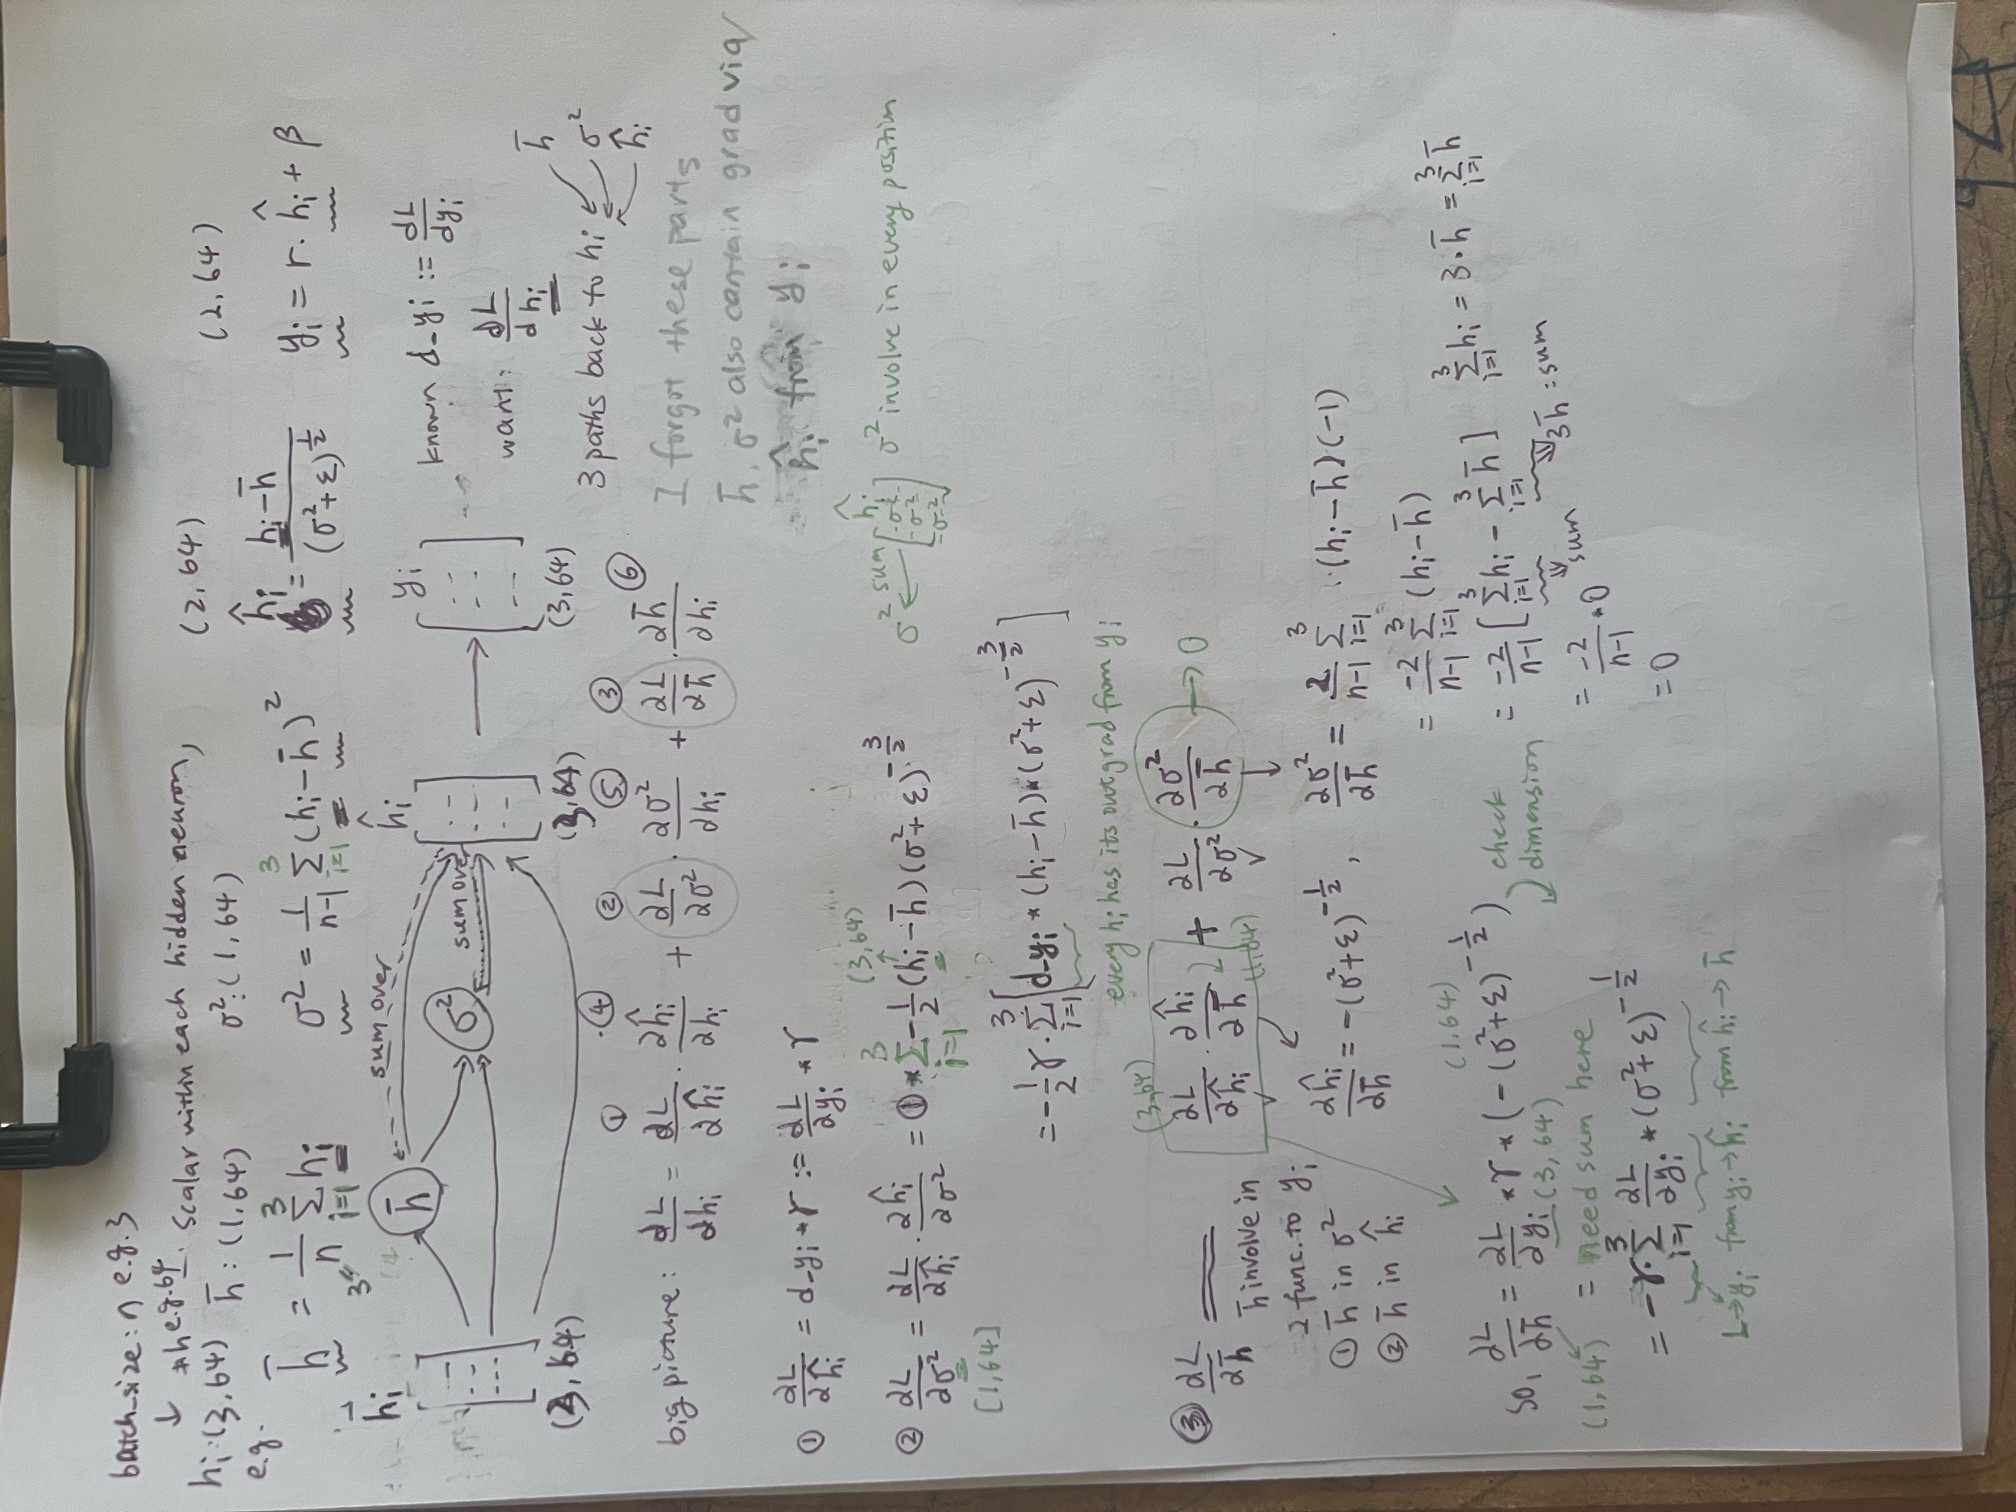

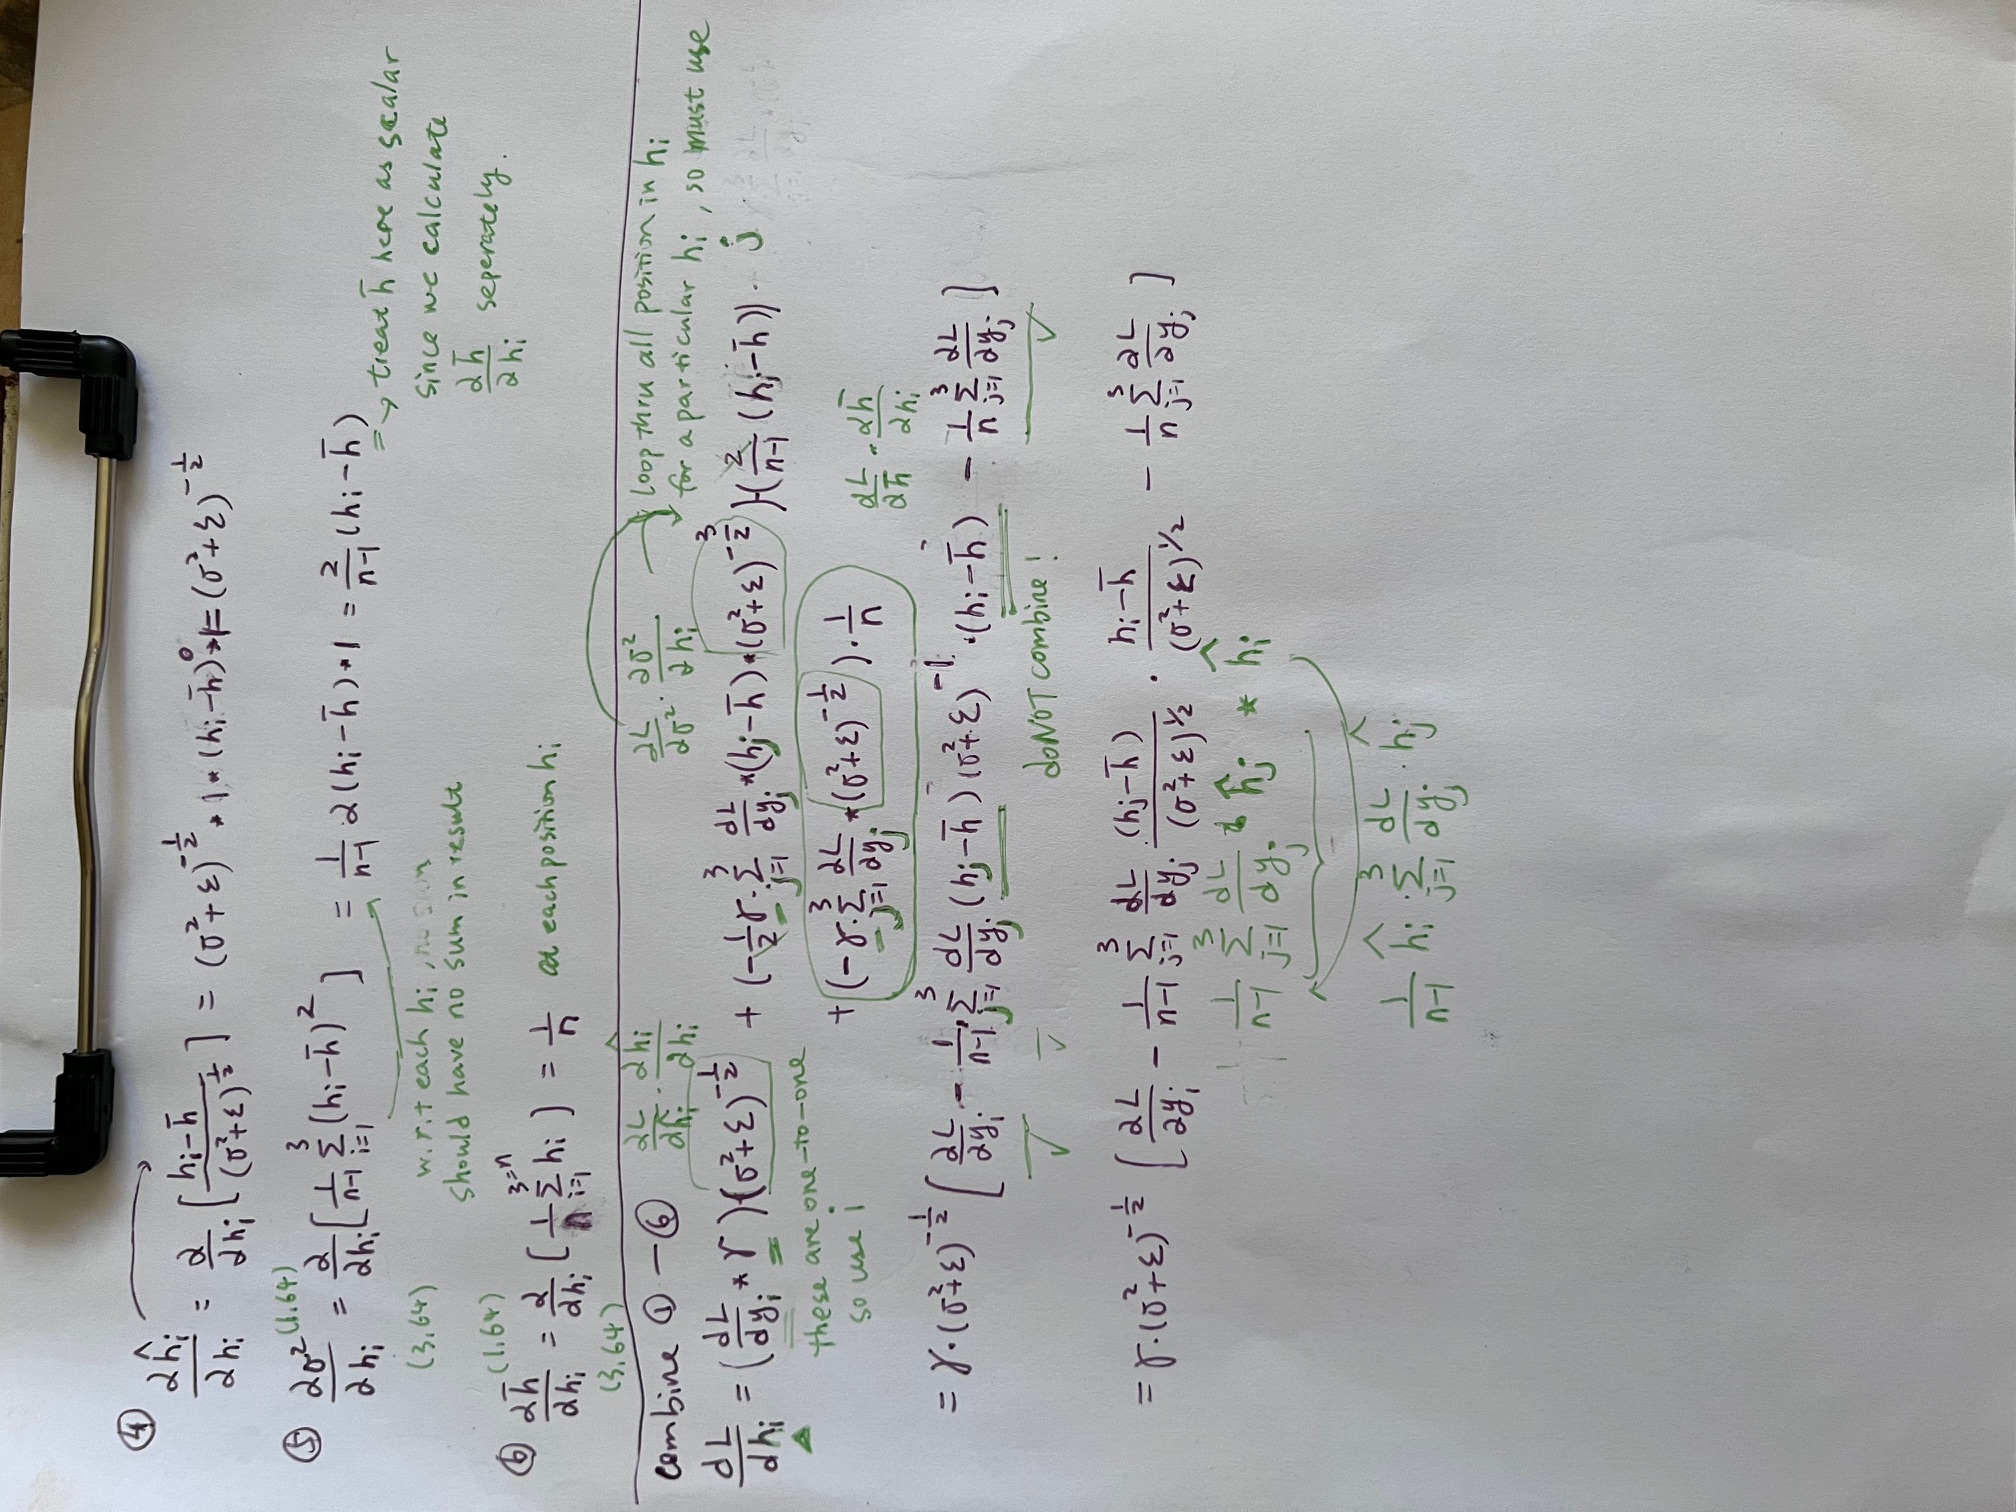

In [32]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
# with torch.no_grad():

# kick off optimization
for i in range(max_steps):

    if i > 1000: # TODO: delete early breaking when you're ready to train the full net
        break
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    bnout = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(bnout) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
      p.grad = None
    loss.backward() # use this for correctness comparisons, delete it later!
    
    # manual backprop! #swole_doge_meme
    # ------------------------------
    # loss to logits
    d_logits = F.softmax(logits, dim=1) * (1.0/batch_size)
    d_logits[range(batch_size), Yb] -= 1.0/batch_size
    
    # 2nd layer backprop
    dh = d_logits @ W2.T
    dW2 = h.T @ d_logits
    db2 = d_logits.sum(0)
    
    # tanh
    d_bnout = (1.0 - h**2) * dh
    
    # batchnorm backprop
    dbngain = (bnraw * d_bnout).sum(0, keepdim=True)
    dbnbias = d_bnout.sum(0, keepdim=True)  
    d_h_prebn =  bngain * (bnvar + 1e-5)**-0.5 * (d_bnout - 1/n * d_bnout.sum(0) - 1/(n-1)* bnraw * ((d_bnout * bnraw).sum(0)))
    
    # 1st layer
    d_embcat = d_h_prebn @ W1.T
    d_W1 = embcat.T @ d_h_prebn
    db1 = d_h_prebn.sum(0)

    # embedding
    d_embd = d_embcat.view(d_embcat.shape[0], block_size, -1)
    d_C = torch.zeros_like(C)
    for k in range(batch_size):
        for step in range(block_size):
            ix = Xb[k][step]   # int representing which character in vocab
            d_C[ix] += d_embd[k][step]
          
    grads = [d_C, d_W1, db1, dW2, db2, dbngain, dbnbias]
    # -----------------
    
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
        #p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
        p.data += -lr * grad # new way of swole doge TODO: enable
    
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())
    

# useful for checking your gradients
for p,g in zip(parameters, grads):
  cmp(str(tuple(p.shape)), g, p)

12297
      0/ 200000: 3.8471
(27, 10)        | exact: False | approximate: True  | maxdiff: 2.2351741790771484e-08
(30, 200)       | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(200,)          | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09
(200, 27)       | exact: False | approximate: True  | maxdiff: 1.862645149230957e-08
(27,)           | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(1, 200)        | exact: False | approximate: True  | maxdiff: 2.7939677238464355e-09
(1, 200)        | exact: False | approximate: True  | maxdiff: 4.6566128730773926e-09


In [17]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total



# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):
    
        # if i > 1000: # TODO: delete early breaking when you're ready to train the full net
        #     break
        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
        
        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        bnout = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(bnout) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function
        
        
        # manual backprop! #swole_doge_meme
        # ------------------------------
        # loss to logits
        d_logits = F.softmax(logits, dim=1) * (1.0/batch_size)
        d_logits[range(batch_size), Yb] -= 1.0/batch_size
        
        # 2nd layer backprop
        dh = d_logits @ W2.T
        dW2 = h.T @ d_logits
        db2 = d_logits.sum(0)
        
        # tanh
        d_bnout = (1.0 - h**2) * dh
        
        # batchnorm backprop
        dbngain = (bnraw * d_bnout).sum(0, keepdim=True)
        dbnbias = d_bnout.sum(0, keepdim=True)  
        d_h_prebn =  bngain * (bnvar + 1e-5)**-0.5 * (d_bnout - 1/n * d_bnout.sum(0) - 1/(n-1)* bnraw * ((d_bnout * bnraw).sum(0)))
        
        # 1st layer
        d_embcat = d_h_prebn @ W1.T
        d_W1 = embcat.T @ d_h_prebn
        db1 = d_h_prebn.sum(0)
    
        # embedding
        d_embd = d_embcat.view(d_embcat.shape[0], block_size, -1)
        d_C = torch.zeros_like(C)
        for k in range(batch_size):
            for step in range(block_size):
                ix = Xb[k][step]   # int representing which character in vocab
                d_C[ix] += d_embd[k][step]
              
        grads = [d_C, d_W1, db1, dW2, db2, dbngain, dbnbias]
        # -----------------
        
        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            
            p.data += -lr * grad # new way of swole doge TODO: enable
        
        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
            lossi.append(loss.log10().item())


12297
      0/ 200000: 3.7845
  10000/ 200000: 2.1955
  20000/ 200000: 2.3829
  30000/ 200000: 2.4512
  40000/ 200000: 2.0071
  50000/ 200000: 2.3691
  60000/ 200000: 2.3756
  70000/ 200000: 2.0551
  80000/ 200000: 2.3633
  90000/ 200000: 2.1223
 100000/ 200000: 1.9804
 110000/ 200000: 2.2444
 120000/ 200000: 1.9858
 130000/ 200000: 2.5147
 140000/ 200000: 2.2654
 150000/ 200000: 2.2266
 160000/ 200000: 1.9954
 170000/ 200000: 1.7993
 180000/ 200000: 1.9655
 190000/ 200000: 1.8938


In [18]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [19]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.0714571475982666
val 2.1104326248168945


In [20]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahzamille.
khi.
mri.
reity.
sachaske.
mahnen.
delynn.
jareei.
nellara.
chaiivan.
leigh.
ham.
joce.
quinn.
saline.
liven.
coraelogiearisi.
jaxen.
dura.
med.
